In [2]:
import fasttext
import os
import pandas as pd
import json
import numpy as np

In [4]:
def Load_files(Cosmetic_file, Clothes_file):
    '''
    Parameters
    ----------
    Cosmetic_file : string
    Clothes_file : string
    The paths of both files

    Returns
    -------
    Dataframe and metadata

    '''
    
    with open(Cosmetic_file, 'r', encoding='utf-8') as f:
        cosmetic = json.load(f)
    with open(Clothes_file, 'r', encoding='utf-8') as f:
        clothes = json.load(f)
        
    cloth_meta = clothes["metadata"]
    cosmetic_meta = cosmetic["metadata"]
    cloth_df = clothes["data"]
    cosmetic_df = cosmetic["data"]
    
    return cloth_meta, cloth_df, cosmetic_meta, cosmetic_df
    
    
def DF_ftz(dataframe, text_tag):
    """
    Format the texts for FastText model.

    Parameters
    ----------
    label_tag: string Column name for labels.
    text_tag: string Column name for text.

    Returns
    ----------
    File path of the formatted text file for FastText.
    """
    formatted_file = "formatted_data.txt"
    with open(formatted_file, "w", encoding="utf-8") as f:
        for _, row in dataframe.iterrows():
            text = row[text_tag]
            f.write(f"{text}\n")
    return formatted_file


In [6]:

def filter_clothes(department="All" ):

    clothDF = pd.DataFrame(cloth_df)
    
    if department == "All":
        return {"filtered": clothDF}
    else:
        Filter = clothDF["Department Name"] == department
        return clothDF[Filter]


def filter_cosmetics(brand="All", category="All"):

    cosmeticDF = pd.DataFrame(cosmetic_df)
    if brand == "All" and category == "All":
        return {"filtered": cosmeticDF}
    elif brand == "All" and category != "All":
        Filter = cosmeticDF["category"] == category
    elif brand != "All" and category == "All":
        Filter = cosmeticDF["brand"] == brand
    else:
        Filter = (cosmeticDF["brand"] == brand) and (cosmetic_df["category"] == category)
    
    return cosmeticDF[Filter]

In [8]:
MODEL_PATH = r"model\clothes_review_sentiment.ftz"
fasttext_model = fasttext.load_model(MODEL_PATH)
COSMETICFILE = r"data_for_webapp\dresses.json"
FASHIONFILE = r"data_for_webapp\amazon_fashion.json"


In [10]:
def root():
    """
    Initialization
    """

    global cloth_meta, cloth_df, Dress_meta, Dress_df
    
    cloth_meta, cloth_df, Dress_meta, Dress_df = Load_files(
        Clothes_file=FASHIONFILE, Cosmetic_file=COSMETICFILE)

    cloth_frame = pd.DataFrame(cloth_df)
    corpus_for_model = list(cloth_frame['Text'])

    predicted_labels = fasttext_model.predict(corpus_for_model, k=1)
    
    labels = np.array(predicted_labels) 
    labels = labels[0,:]
    
    label_vec = []
    for l in labels:
        logic = l[0].strip('__label__')
        logic = eval(logic)
        label_vec.append(logic)
        
    cloth_frame['label'] = label_vec
    cloth_df = cloth_frame.to_dict()
    
    
    
    return {"message": "Data loaded"}

In [12]:
root()

{'message': 'Data loaded'}

In [67]:
cloth_meta

{'departments': ['Intimate', 'Dresses', 'Bottoms', 'Tops', 'Jackets', 'Trend'],
 'source': 'https://www.kaggle.com/datasets/jocelyndumlao/consumer-review-of-clothing-product'}

In [87]:
pd.DataFrame(cloth_df)

,Clothing ID,Department Name,Text,label
0,767,Intimate,absolutely wonderful silky sexy comfortable,1.0
1,1080,Dresses,love dress sooo pretty happened find store im ...,1.0
2,1077,Dresses,major design flaw such high hope dress really ...,0.0
3,1049,Bottoms,favorite buy love love love jumpsuit fun flirt...,1.0
4,847,Tops,flattering shirt shirt very flattering due adj...,1.0
...,...,...,...,...
23481,1104,Dresses,great dress many occasion very happy snag dres...,1.0
23482,862,Tops,wish made cotton reminds maternity clothes sof...,0.0
23483,1104,Dresses,cute see fit well top very see never would wor...,0.0
23484,1084,Dresses,very cute dress perfect summer party bought dr...,0.0


In [125]:
A = filter_clothes("Bottoms")

In [127]:
print(f"Positive: {A[A['label'] == 1].count()} \n"
        f"Neutral: {A[A['label'] == 0].count()}\n"
        f"Negative: {A[A['label'] == -1].count()}"
     )

Positive: Clothing ID        2367
Department Name    2367
Text               2367
label              2367
dtype: int64 
Neutral: Clothing ID        1019
Department Name    1019
Text               1019
label              1019
dtype: int64
Negative: Clothing ID        276
Department Name    276
Text               276
label              276
dtype: int64


In [131]:
A[A['label'] == 1]

,Clothing ID,Department Name,Text,label
3,1049,Bottoms,favorite buy love love love jumpsuit fun flirt...,1.0
30,1060,Bottoms,beautifully made pant trend flared crop much c...,1.0
32,1060,Bottoms,love pant pant even better person only downsid...,1.0
35,1060,Bottoms,lovely wouldnt given second look tried store w...,1.0
36,1002,Bottoms,comfortable skirt span season easily not most ...,1.0
...,...,...,...,...
23377,630,Bottoms,new summer staple pretty summer very lightweig...,1.0
23395,630,Bottoms,best little romper ever tried dont typically l...,1.0
23415,1020,Bottoms,beautiful unique piece love usually size botto...,1.0
23419,1020,Bottoms,cute skirt cute staple wardrobe wear boot boot...,1.0


In [135]:
A["label"].count()

3662

In [139]:
import spacy
from collections import Counter
from wordcloud import WordCloud
import io
from fastapi.responses import StreamingResponse
import matplotlib.pyplot as plt

In [147]:
def sentiment_breakdown(dataframe):
    
    tot = dataframe['label'].count()
    
    positive = dataframe[dataframe['label']==1]
    neutral = dataframe[dataframe['label']==0]
    negative = dataframe[dataframe['label']==-1]
    
    positive_percent = positive.count()/tot
    neutral_percent = neutral.count()/tot
    negative_percent = negative.count()/tot
    
    return {"data":[positive, neutral, negative], "percentage": [positive_percent, neutral_percent, negative_percent]}
    

def keyword_analysis(positive, neutral, negative):
    """
    Return: Overall Top 10, Negative Top 10, Word_Clouds (Overall and negative)
    Here we use Spacy because we only want nouns as the keywords
    """
    # Load spaCy model
    nlp = spacy.load("en_core_web_sm")
    


    pos_count = Counter()
    neu_count = Counter()
    neg_count = Counter()

    # positive
    pos_docs = nlp.pipe(list(positive["Text"]), batch_size=200, n_process=-1)  # Use multiple processes for speed

    for doc in pos_docs:
        nouns = [token.text.lower() for token in doc if token.pos_ == "NOUN"]
        pos_count.update(nouns)

    # neutral
    neu_docs = nlp.pipe(list(neutral["Text"]), batch_size=200, n_process=-1)  # Use multiple processes for speed

    for doc in neu_docs:
        nouns = [token.text.lower() for token in doc if token.pos_ == "NOUN"]
        neu_count.update(nouns)
        
    # negative
    neg_docs = nlp.pipe(list(negative["Text"]), batch_size=200, n_process=-1)  # Use multiple processes for speed

    for doc in neg_docs:
        nouns = [token.text.lower() for token in doc if token.pos_ == "NOUN"]
        neg_count.update(nouns)
                         
        
    # Top 10 keywords
    tot_counter = pos_count + neg_count + neu_count
    Overall_top10 = tot_counter.most_common(10)
    Negative_top10 = neg_count.most_common(10)
    
    WC_bytes = {}
    # Generate word clouds + save as byte streams
    if tot_counter:
       
        wordcloud = WordCloud(width=800, height=600, background_color="white").generate_from_frequencies(tot_counter)
        # To bytes
        img_byte_array = io.BytesIO()
        wordcloud.to_image().save(img_byte_array, format="PNG")
        img_byte_array.seek(0)
        WC_bytes["overall"] = img_byte_array
    
    if neg_count:
       
        wordcloud = WordCloud(width=800, height=600, background_color="white").generate_from_frequencies(neg_count)
        # To bytes
        img_byte_array = io.BytesIO()
        wordcloud.to_image().save(img_byte_array, format="PNG")
        img_byte_array.seek(0)
        WC_bytes["neg"] = img_byte_array

    return Overall_top10, Negative_top10, WC_bytes

In [141]:
DF = pd.DataFrame(cloth_df)

In [149]:
res = sentiment_breakdown(DF)

In [159]:
pos, mid, neg = res["data"]

In [167]:
keyword_analysis(pos, mid, neg)

([('dress', 12022),
  ('size', 8826),
  ('love', 8605),
  ('color', 7125),
  ('fabric', 5064),
  ('top', 3516),
  ('shirt', 3058),
  ('sweater', 2919),
  ('material', 2673),
  ('length', 2627)],
 [('dress', 1119),
  ('size', 724),
  ('fabric', 556),
  ('color', 461),
  ('shirt', 336),
  ('quality', 334),
  ('material', 320),
  ('top', 312),
  ('way', 301),
  ('love', 286)],
 {'overall': <_io.BytesIO at 0x23fdffd7720>,
  'neg': <_io.BytesIO at 0x23fe03b1450>})

In [257]:
def keyword_analysis_fast(positive, neutral, negative):
    stop_words = set(stopwords.words("english"))
    neutral_clothing_terms = {"wedding","party","office","casual","formal","vacation","trendy","classic","vintage","modern","colorful","plain",
                              "pattern","solid","oversized","snug","loose","stretchy","tailored","daily","travel","workout","lounge","outdoor","indoor",
                              "synthetic","jacket","dress","jeans","blouse","skirt","hoodie","buttons","zippers","straps","pockets","shirt", "shirts"
                              "wrinkle-free","delicate","dry-clean","black","white","floral","polka dots","stripes","medium","large","petite","plus-size", "jean", "sweater"}
    neutral_adj_and_verbs = {
    "great", "perfect", "amazing", "beautiful", "nice", "good", "bad", "awesome", "cool",
    "okay", "fine", "best", "better", "favorite", "poor", "decent", "look", "would", "is",
    "are", "was", "were", "be", "have", "had", "love", "like", "want", "get", "go", "try",
    "buy", "keep", "return", "need", "think", "seem", "feel", "give", "say", "make", "find",
    "back", "use", "see", "put", "take", "move", "bring", "choose", "im", "wear", "even", "really",
    "top", "bottom", "looked", "way", "order", "ordered", "much", "way", "one", "run", "bit", "bought",
    "tried", "didn't", "also", "little",  "disappointed", "well"
}
    stop_words = stop_words.union(neutral_clothing_terms)
    stop_words = stop_words.union(neutral_adj_and_verbs)
    def extract_keywords(texts, top_n=10):
        counter = Counter()
        for text in texts:
            words = [word.lower() for word in text.split() if word.lower() not in stop_words]
            counter.update(words)
        return counter.most_common(top_n)

    # Extract keywords
    positive_keywords = extract_keywords(list(positive["Text"]))
    neutral_keywords = extract_keywords(list(neutral["Text"]))
    negative_keywords = extract_keywords(list(negative["Text"]))

    # Combine results
    neg_count = Counter(dict(negative_keywords))
    overall_counter = Counter(dict(positive_keywords)) + Counter(dict(neutral_keywords)) + Counter(dict(negative_keywords))
    overall_keywords = overall_counter.most_common(15)

    WC_bytes = {}
    # Generate word clouds + save as byte streams
    if overall_counter:
       
        wordcloud = WordCloud(width=800, height=600, background_color="white").generate_from_frequencies(overall_counter)
        # To bytes
        img_byte_array = io.BytesIO()
        wordcloud.to_image().save(img_byte_array, format="PNG")
        img_byte_array.seek(0)
        WC_bytes["overall"] = img_byte_array
    
    if neg_count:
       
        wordcloud = WordCloud(width=800, height=600, background_color="white").generate_from_frequencies(neg_count)
        # To bytes
        img_byte_array = io.BytesIO()
        wordcloud.to_image().save(img_byte_array, format="PNG")
        img_byte_array.seek(0)
        WC_bytes["neg"] = img_byte_array
    
    return overall_keywords, negative_keywords, WC_bytes

In [253]:
from nltk.corpus import stopwords
import nltk


In [259]:
keyword_analysis_fast(pos, mid, neg)

([('fit', 10771),
  ('size', 9579),
  ('color', 7357),
  ('fabric', 5127),
  ('small', 4908),
  ('cute', 4560),
  ('comfortable', 2922),
  ('flattering', 2898),
  ('soft', 2821),
  ('length', 1661),
  ('material', 1501),
  ('short', 1395),
  ('pretty', 1322),
  ('waist', 1033),
  ('quality', 334)],
 [('size', 794),
  ('fit', 725),
  ('fabric', 565),
  ('small', 549),
  ('color', 476),
  ('material', 351),
  ('quality', 334),
  ('cute', 288),
  ('retailer', 283),
  ('short', 283)],
 {'overall': <_io.BytesIO at 0x23fe3b60450>,
  'neg': <_io.BytesIO at 0x23fe3456ef0>})

In [261]:
cosmetic_meta

{'brands': ['Drunk Elephant',
  'Laura Mercier',
  'Natasha Denona',
  'Ilia Beauty',
  'Charlotte Tilbury',
  'Danessa Myricks',
  'Bourjois',
  'IT Cosmetics',
  'Fenty Beauty',
  'Sisley',
  'Juvia’s Place',
  'NARS',
  'ColourPop',
  'Huda Beauty',
  'Tatcha',
  'Kiehl’s',
  'Tarte',
  'Glossier',
  'Make Up For Ever',
  'Anastasia Beverly Hills',
  'E.l.f.',
  'Hourglass',
  'Pat McGrath Labs',
  'Too Faced',
  'Perricone MD',
  'RMS Beauty',
  'Urban Decay',
  'Rare Beauty',
  'Becca',
  'Patrick Ta',
  'Shiseido',
  'Kylie Cosmetics',
  'Bite Beauty',
  'Yves Saint Laurent',
  'Bobby Brown',
  'Farsali',
  'Morphe',
  'Milk Makeup',
  'Clinique',
  'KVD Beauty'],
 'category': ['Blush',
  'Makeup Remover',
  'Highlighter',
  'Face Mask',
  'Foundation',
  'Powder',
  'Lip Gloss',
  'CC Cream',
  'Eye Shadow',
  'Concealer',
  'Eyeliner',
  'Lipstick',
  'Setting Spray',
  'Cleanser',
  'Bronzer',
  'Primer',
  'Face Oil',
  'Contour',
  'Mascara',
  'Serum',
  'BB Cream',
  'Exfo

In [287]:
def filter_cosmetics(category, brand):

    cosmeticDF = pd.DataFrame(cosmetic_df)
   
    Filter = (cosmeticDF["Category"] == category)
    product = (cosmeticDF["Category"] == category) & (cosmeticDF["Brand"] == brand)
    
    return cosmeticDF[Filter], cosmeticDF[product]

In [293]:
f, p = filter_cosmetics(list(cosmetic_meta["category"])[0], list(cosmetic_meta["brands"])[0])
p

,Product_Name,Brand,Category,Price_USD,Rating,Gender_Target,Cruelty_Free,Country_of_Origin,Main_Ingredient
0,Ultra Face Mask,Drunk Elephant,Blush,67.85,1.4,Female,False,Australia,Retinol
809,Ultra Contour,Drunk Elephant,Blush,12.80,3.4,Female,False,Italy,Aloe Vera
1811,Super Blush,Drunk Elephant,Blush,47.72,4.7,Unisex,False,Italy,Retinol
1975,Super Lipstick,Drunk Elephant,Blush,30.91,2.8,Female,False,Italy,Vitamin C
2970,Ultra Exfoliator,Drunk Elephant,Blush,25.29,1.9,Female,True,USA,Salicylic Acid
3219,Perfect BB Cream,Drunk Elephant,Blush,45.97,4.6,Unisex,True,UK,Vitamin C
9393,Super Lip Liner,Drunk Elephant,Blush,52.23,1.5,Female,True,Japan,Aloe Vera
13395,Divine Eyeliner,Drunk Elephant,Blush,19.43,3.1,Female,True,Japan,Vitamin C
14121,Ultra Concealer,Drunk Elephant,Blush,89.12,2.7,Male,True,France,Aloe Vera


In [299]:
A = pd.DataFrame(cosmetic_df)
A

,Product_Name,Brand,Category,Price_USD,Rating,Gender_Target,Cruelty_Free,Country_of_Origin,Main_Ingredient
0,Ultra Face Mask,Drunk Elephant,Blush,67.85,1.4,Female,False,Australia,Retinol
1,Ultra Lipstick,Laura Mercier,Makeup Remover,116.43,4.2,Unisex,False,UK,Shea Butter
2,Ultra Serum,Natasha Denona,Highlighter,90.84,1.6,Male,True,Italy,Aloe Vera
3,Divine Serum,Ilia Beauty,Face Mask,55.17,3.2,Male,True,South Korea,Glycerin
4,Super Foundation,Charlotte Tilbury,Highlighter,140.56,1.7,Female,False,Germany,Glycerin
...,...,...,...,...,...,...,...,...,...
14995,Magic Eyeliner,Patrick Ta,Face Mask,131.64,2.8,Unisex,True,Italy,Aloe Vera
14996,Perfect Powder,Farsali,Serum,76.35,2.1,Unisex,True,USA,Salicylic Acid
14997,Magic Serum,Kiehl’s,Highlighter,65.37,4.2,Unisex,False,South Korea,Shea Butter
14998,Magic Mascara,Perricone MD,Powder,59.93,4.8,Male,True,USA,Aloe Vera


In [307]:
A[A["Category"] == "Face Mask"]

,Product_Name,Brand,Category,Price_USD,Rating,Gender_Target,Cruelty_Free,Country_of_Origin,Main_Ingredient
3,Divine Serum,Ilia Beauty,Face Mask,55.17,3.2,Male,True,South Korea,Glycerin
9,Perfect Bronzer,Fenty Beauty,Face Mask,133.57,4.4,Female,False,Japan,Hyaluronic Acid
22,Divine Cleanser,Fenty Beauty,Face Mask,119.26,4.6,Male,False,Japan,Hyaluronic Acid
56,Divine Cleanser,Becca,Face Mask,49.67,1.9,Female,False,Germany,Hyaluronic Acid
59,Super Blush,Yves Saint Laurent,Face Mask,110.51,4.2,Male,False,UK,Vitamin C
...,...,...,...,...,...,...,...,...,...
14905,Perfect Mascara,Juvia’s Place,Face Mask,34.35,3.0,Unisex,True,Australia,Hyaluronic Acid
14916,Super Blush,Natasha Denona,Face Mask,109.64,2.7,Female,True,Australia,Aloe Vera
14944,Magic Lip Gloss,Patrick Ta,Face Mask,16.78,1.1,Male,True,Italy,Hyaluronic Acid
14958,Ultra BB Cream,Kiehl’s,Face Mask,93.80,4.4,Male,False,Italy,Vitamin C


In [271]:
cosmetic_meta['category']

['Blush',
 'Makeup Remover',
 'Highlighter',
 'Face Mask',
 'Foundation',
 'Powder',
 'Lip Gloss',
 'CC Cream',
 'Eye Shadow',
 'Concealer',
 'Eyeliner',
 'Lipstick',
 'Setting Spray',
 'Cleanser',
 'Bronzer',
 'Primer',
 'Face Oil',
 'Contour',
 'Mascara',
 'Serum',
 'BB Cream',
 'Exfoliator',
 'Lip Liner',
 'Moisturizer']

In [291]:
list(cosmetic_meta["category"])[0]

'Blush'

## Next section, for competitive analysis

In [160]:
import google.generativeai as genai


import spacy
from collections import Counter
from wordcloud import WordCloud
import io
from fastapi.responses import StreamingResponse
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import base64

from sklearn.cluster import MiniBatchKMeans

In [16]:
def filter_Dress(brand):

    DressDF = pd.DataFrame(Dress_df)
   
    Filter = (DressDF["Brand"] == brand)
    
    return DressDF[Filter]

In [216]:
def kmeans_clustering(dataframe, n_clusters=7):
    """
    Recommended k: the number of brands
    """
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1024)
    X = dataframe[['Price', 'Rating']]
    kmeans.fit(X)
    return kmeans.cluster_centers_, kmeans.labels_

In [100]:
brand = "Jigsaw"

In [102]:
All_items = pd.DataFrame(Dress_df)
Selected_Brand = filter_Dress(brand)
All_stats = pd.DataFrame(Dress_meta["stats"])
Selected_stat = All_stats[All_stats["Brand"]=="brand"]

In [104]:
All_items["Brand"].value_counts()

Burberry             18536
Tommy Hilfiger       12385
Calvin Klein          8108
Jigsaw                5622
Alexander McQueen     2889
Mulberry              1044
Ralph Lauren          1044
Ted Baker              368
Name: Brand, dtype: int64

In [150]:
All_stats

,Brand,Price,Weighted Price Average,Rating,Weighted Rating Average
0,Alexander McQueen,1232.002316,1234.040239,4.454491,4.449204
1,Burberry,988.299681,988.627690,4.280091,4.280877
2,Calvin Klein,267.676490,267.511632,3.797445,3.794786
3,Jigsaw,214.385589,214.517529,3.505072,3.497689
4,Mulberry,361.246571,362.320618,3.989894,3.986183
5,Ralph Lauren,158.100316,158.241185,2.975782,2.996203
6,Ted Baker,110.400514,109.447203,2.783406,2.803759
7,Tommy Hilfiger,186.398795,186.568540,3.200482,3.201431


In [257]:
from matplotlib.colors import ListedColormap
colors = ["#B9D9EB", "#B0C4DE", "#E0FFFF", "#E1EBEE"]
custom_cmap = ListedColormap(colors)


from matplotlib.lines import Line2D

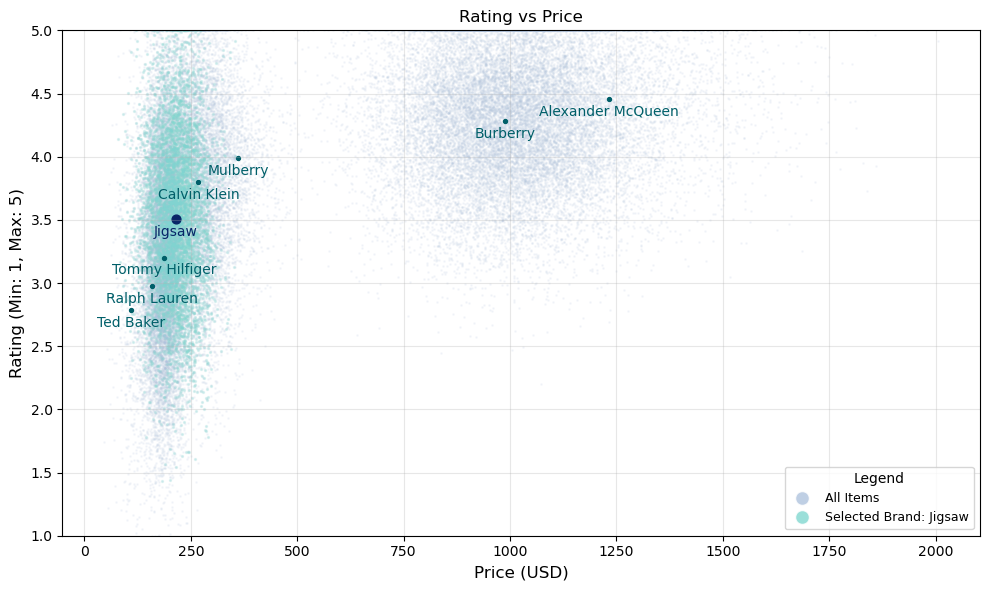

In [291]:
# Create a scatter plot for Rating vs Price
plt.figure(figsize=(10, 6))


# Plot all data points with small dots
plt.scatter(All_items['Price'], All_items['Rating'], color = "#B0C4DE", alpha=0.1, s=1, label="All Items")

# Highlight selected brand with larger dots
plt.scatter(Selected_Brand['Price'], Selected_Brand['Rating'], color = "#81D8D0", alpha=0.2, s=2, label=f"{Selected_Brand['Brand'][0]}")






# Add average price and rating for each brand
for _, row in All_stats.iterrows():
    avg_price = row['Price']
    avg_rating = row['Rating']
    brand_name = row['Brand']
    color = '#005f69' if brand_name not in Selected_Brand['Brand'].unique() else '#082567'
    s = 8 if brand_name not in Selected_Brand['Brand'].unique() else 40
    plt.scatter(avg_price, avg_rating, color=color, s=s, marker='o')
    plt.text(avg_price, avg_rating - 0.1, brand_name, fontsize=10, ha='center', va='center', color=color)    


legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='All Items', markerfacecolor="#B0C4DE", markersize=10, alpha=0.8),
        Line2D([0], [0], marker='o', color='w', label=f"Selected Brand: {Selected_Brand['Brand'][0]}", markerfacecolor="#81D8D0", markersize=10, alpha=0.8),
    ] 
plt.legend(handles=legend_elements, title="Legend", fontsize=9, loc='best')

# Add labels and legend
plt.title("Rating vs Price", fontsize=12)
plt.xlabel("Price (USD)", fontsize=12)
plt.ylabel("Rating (Min: 1, Max: 5)", fontsize=12)
#plt.legend(title="Legend", fontsize=12)
plt.grid(alpha=0.3)
plt.ylim(1, 5)
# Show plot
plt.tight_layout()
plt.show()

In [289]:
def rating_price_scatter(All_items, Selected_Brand, All_stats, n_clusters=4):
    """
    Create a scatter plot for Rating vs Price with KMeans cluster centers.

    Parameters:
        All_items (pd.DataFrame): Dataframe containing all items.
        Selected_Brand (pd.DataFrame): Dataframe containing selected brand items.
        n_clusters (int): Number of clusters for KMeans.

    Returns:
        str: Base64 encoded string of the plot image.
    """
    # Create a scatter plot for Rating vs Price
    plt.figure(figsize=(10, 6))

    plt.scatter(All_items['Price'], All_items['Rating'], color = "#B0C4DE", alpha=0.1, s=1, label="All Items")
    plt.scatter(Selected_Brand['Price'], Selected_Brand['Rating'], color = "#81D8D0", alpha=0.2, s=2, label=f"{Selected_Brand['Brand'][0]}")


    # Add average price and rating for each brand
    for _, row in All_stats.iterrows():
        avg_price = row['Price']
        avg_rating = row['Rating']
        brand_name = row['Brand']
        color = '#005f69' if brand_name not in Selected_Brand['Brand'].unique() else '#082567'
        s = 8 if brand_name not in Selected_Brand['Brand'].unique() else 40
        plt.scatter(avg_price, avg_rating, color=color, s=s, marker='o')
        plt.text(avg_price, avg_rating - 0.1, brand_name, fontsize=10, ha='center', va='center', color=color)    


    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='All Items', markerfacecolor="#B0C4DE", markersize=10, alpha=0.8),
        Line2D([0], [0], marker='o', color='w', label=f"Selected Brand: {Selected_Brand['Brand'][0]}", markerfacecolor="#81D8D0", markersize=10, alpha=0.8),
        ] 
    plt.legend(handles=legend_elements, title="Legend", fontsize=9, loc='best')

    # Add labels
    plt.title("Rating vs Price", fontsize=12)
    plt.xlabel("Price (USD)", fontsize=12)
    plt.ylabel("Rating (Min: 1, Max: 5)", fontsize=12)
    #plt.legend(title="Legend", fontsize=12)
    plt.grid(alpha=0.3)
    plt.ylim(1, 5)
    plt.tight_layout()

    # Save plot to a BytesIO buffer
    buf = io.BytesIO()
    plt.tight_layout()
    plt.savefig(buf, format='png', dpi=100)
    plt.close()
    buf.seek(0)

    # Encode the image to base64
    encoded_image = base64.b64encode(buf.getvalue()).decode('utf-8')
    buf.close()

    return encoded_image

In [287]:
rating_price_scatter(All_items, Selected_Brand, All_stats)

'iVBORw0KGgoAAAANSUhEUgAAA+gAAAJYCAYAAADxHswlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9edAlWV7Xj7/Olpl3eZaq7urpnhl62ERcUFC2Edk0BJkA/gACUZBhJBADIULFQAgWBUaUr4YibkQIzoCEgBAIaDigBIsROgRjDKH+DEIHZRhm6bWqnuXezDzr74+TmU/e+9yn6nmqqruru/MdUVFV9+bNPHny5Dnn8/m8P++PSCklJkyYMGHChAkTJkyYMGHChAkvKeRL3YAJEyZMmDBhwoQJEyZMmDBhwmSgT5gwYcKECRMmTJgwYcKECQ8FJgN9woQJEyZMmDBhwoQJEyZMeAgwGegTJkyYMGHChAkTJkyYMGHCQ4DJQJ8wYcKECRMmTJgwYcKECRMeAkwG+oQJEyZMmDBhwoQJEyZMmPAQYDLQJ0yYMGHChAkTJkyYMGHChIcAk4E+YcKECRMmTJgwYcKECRMmPASYDPQJEyZMmDBhwoQJEyZMmDDhIcBkoE+YMGHChAkTJkyYMGHChAkPASYDfcKECRMmTJgwYcKECRMmTHgIMBnoEyZMmDBhwoQJEyZMmDBhwkOAyUCfMGHChAkTJkyYMGHChAkTHgJMBvqECRMmTJgwYcKECRMmTJjwEGAy0CdMmDBhwoR7xNvf/naEEMMfrTVPPPEEX/ZlX8Z73vOeez7v93zP9/AzP/Mz5z7/lV/5FYQQ/Mqv/Mq9N/ohxa6+fP3rX89b3vIWPvCBD1zqHF/1VV/Fh3/4h7+wDZ0wYcKECRNeQEwG+oQJEyZMmHCfeNvb3sY73/lOfvEXf5Gv//qv5+d+7uf443/8j3Pr1q17Ot9FBvof+SN/hHe+8538kT/yR+6zxQ8v+r78T//pP/E

In [295]:
DF= pd.DataFrame(Dress_df)
DFStat = pd.DataFrame(Dress_meta['stats'])

In [297]:
variance_df = DF.groupby('Brand')[['Price', 'Rating']].var().reset_index()
variance_df.rename(columns={'Price': 'Price Variance', 'Rating': 'Rating Variance'}, inplace=True)


In [299]:
variance_df

,Brand,Price Variance,Rating Variance
0,Alexander McQueen,41194.649643,0.196236
1,Burberry,22692.540706,0.217854
2,Calvin Klein,2592.302069,0.460379
3,Jigsaw,1638.281038,0.366468
4,Mulberry,3548.685284,0.162033
5,Ralph Lauren,910.445462,0.665052
6,Ted Baker,494.233871,0.819477
7,Tommy Hilfiger,634.746793,0.476478


In [313]:
DFStat

,Brand,Price,Weighted Price Average,Rating,Weighted Rating Average,Price Var,Rating Var
0,Alexander McQueen,1232.002316,1234.040239,4.454491,4.449204,41194.649643,0.196236
1,Burberry,988.299681,988.627690,4.280091,4.280877,22692.540706,0.217854
2,Calvin Klein,267.676490,267.511632,3.797445,3.794786,2592.302069,0.460379
3,Jigsaw,214.385589,214.517529,3.505072,3.497689,1638.281038,0.366468
4,Mulberry,361.246571,362.320618,3.989894,3.986183,3548.685284,0.162033
5,Ralph Lauren,158.100316,158.241185,2.975782,2.996203,910.445462,0.665052
6,Ted Baker,110.400514,109.447203,2.783406,2.803759,494.233871,0.819477
7,Tommy Hilfiger,186.398795,186.568540,3.200482,3.201431,634.746793,0.476478


In [327]:
DFStat["Rating Min"] = list(stats_df["Min_Rating"]) 

In [315]:
stats_df = DF.groupby('Brand').agg(
        Price_Variance=('Price', 'var'),
        Rating_Variance=('Rating', 'var'),
        Max_Price=('Price', 'max'),
        Min_Price=('Price', 'min'),
        Max_Rating=('Rating', 'max'),
        Min_Rating=('Rating', lambda x: x[x >= 1].min())  # Ensure rating is not lower than 1
    ).reset_index()

In [331]:
Dress_meta["stats"] = DFStat.to_dict()

In [341]:
with open(r'data_for_webapp/dresses.json', 'w') as file:
    json.dump(D, file, indent=4)

In [335]:
D

{'metadata': {'info': {'brands': ['Alexander McQueen',
    'Burberry',
    'Calvin Klein',
    'Jigsaw',
    'Mulberry',
    'Ralph Lauren',
    'Ted Baker',
    'Tommy Hilfiger']},
  'stats': {'Brand': {'0': 'Alexander McQueen',
    '1': 'Burberry',
    '2': 'Calvin Klein',
    '3': 'Jigsaw',
    '4': 'Mulberry',
    '5': 'Ralph Lauren',
    '6': 'Ted Baker',
    '7': 'Tommy Hilfiger'},
   'Price': {'0': 1232.002315923624,
    '1': 988.2996807308901,
    '2': 267.67649007827765,
    '3': 214.38558852788583,
    '4': 361.2465705900883,
    '5': 158.1003155265594,
    '6': 110.40051429013562,
    '7': 186.398794644221},
   'Weighted Price Average': {'0': 1234.040239446469,
    '1': 988.6276902317608,
    '2': 267.5116315037038,
    '3': 214.51752946053108,
    '4': 362.32061768681115,
    '5': 158.24118476657588,
    '6': 109.44720349577109,
    '7': 186.5685404484955},
   'Rating': {'0': 4.454491136056109,
    '1': 4.280090683818873,
    '2': 3.79744526535172,
    '3': 3.50507230135125

In [337]:
D["metadata"]["stats"] = DFStat.to_dict()


In [351]:
def analyze_price_ranges(stats):
    """
    Show price distribution and variance for brands.
    """
    plt.figure(figsize=(12, 6))

    brands = stats['Brand']
    means = stats['Price']
    variances = stats['Price Var']

    # Whisker ranges
    whiskers_min = means - 1.96 * (variances**0.5)
    whiskers_max = means + 1.96 * (variances**0.5)

    # Plot
    for i, (brand, mean, w_min, w_max) in enumerate(zip(brands, means, whiskers_min, whiskers_max)):
        plt.scatter(mean, i, color='red', label='Avg' if i == 0 else "")
        plt.plot([w_min, w_max], [i, i], color='blue', alpha=0.7, label='Range' if i == 0 else "")

    # Labels
    plt.title("Price Range by Brand", fontsize=14)
    plt.ylabel("Brand", fontsize=12)
    plt.xlabel("Price", fontsize=12)
    plt.yticks(range(len(brands)), brands)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

def analyze_ratings(stats):
    """
    Show ratings and variance for brands.
    """
    plt.figure(figsize=(12, 6))

    brands = stats['Brand']
    means = stats['Rating']
    variances = stats['Rating Var']

    # Whisker ranges
    whiskers_min = means - 1.96 * (variances**0.5)
    whiskers_max = means + 1.96 * (variances**0.5)

    # Plot
    for i, (brand, mean, w_min, w_max) in enumerate(zip(brands, means, whiskers_min, whiskers_max)):
        plt.barh(i, mean, color='#66A5AD', alpha=0.7, label='Avg' if i == 0 else "")
        plt.plot([w_min, w_max], [i, i], color='blue', alpha=0.7, label='Range' if i == 0 else "")

    # Labels
    plt.title("Rating by Brand", fontsize=14)
    plt.xlabel("Rating", fontsize=12)
    plt.ylabel("Brand", fontsize=12)
    plt.yticks(range(len(brands)), brands)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


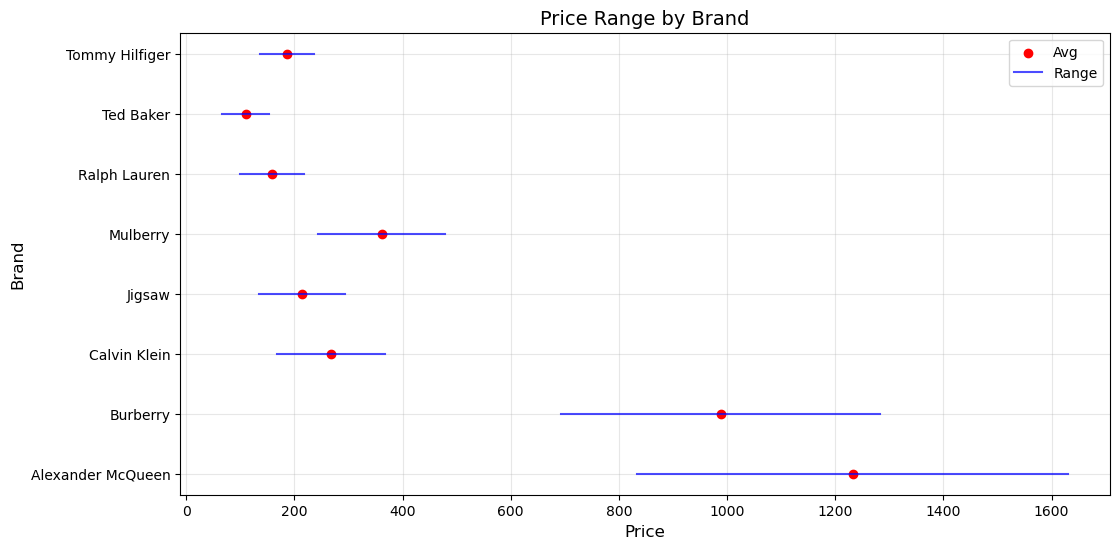

In [353]:
analyze_price_ranges(DFStat)

<Figure size 1200x600 with 0 Axes>

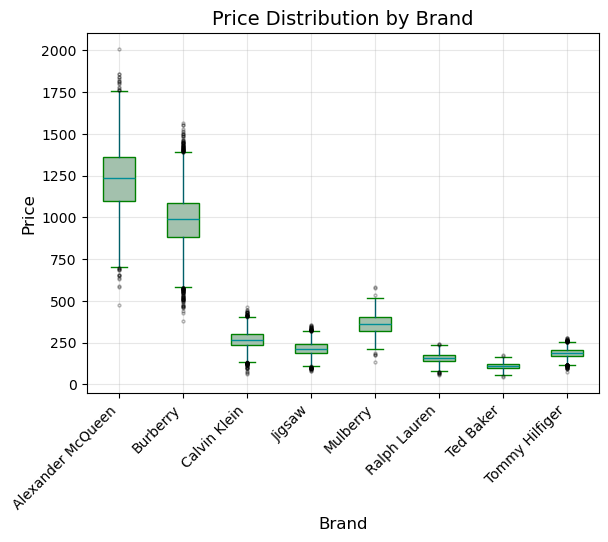

In [379]:

    # Custom color scheme with shades of green
plt.figure(figsize=(12, 6))
boxprops = dict(facecolor='#A3C1AD', color='green')
medianprops = dict(color='#008E97', markersize=5)
whiskerprops = dict(color='#005f69')
capprops = dict(color='green')
flierprops = dict(marker='o', color='#8DA399', alpha=0.3, markersize=2) 

    # Create boxplot
DF.boxplot(column='Price', by='Brand', grid=False, patch_artist=True,
               boxprops=boxprops, medianprops=medianprops,
               whiskerprops=whiskerprops, capprops=capprops,
               flierprops=flierprops)

    # Labels
plt.title("Price Distribution by Brand", fontsize=14)
plt.suptitle("")  # Remove default title
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.show()


<Figure size 1200x600 with 0 Axes>

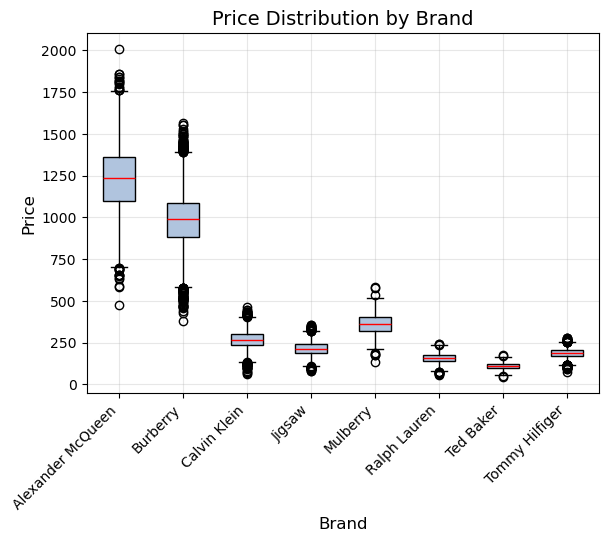

In [361]:
Price_boxplot(DF)

In [381]:
import google.generativeai as genai

with open(r"D:\api_key.txt", "r") as file:
    
    api_key = file.read().strip()
genai.configure(api_key=api_key)
client = genai.GenerativeModel("gemini-1.5-flash", system_instruction="You are a data analyst.")

In [395]:
brand = DFStat[DFStat["Brand"] == brand]

prompt = (f"We are analyzing {brand.to_dict()} among {DFStat.to_dict()}"
              " Return full sentences by filling in the blanks:\n")
    
prompt1 = prompt + (f"{brand['Brand']} is generally within a (high/median/low)"
                        " price range. The closest brand in terms of price is ()."
                        " (brand name) has (number) major competitors within similar price range."
                        " Its overall rating (number) is top (percentile) among all brands, and "
                        "is (higher/lower/similar) to major competitor within the same price range.")
    

C:\Users\yyBee\AppData\Local\Temp\ipykernel_6028\851685425.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  brand = DFStat[DFStat["Brand"] == brand]


In [393]:
client.generate_content(prompt1)

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "The current brand: Alexander McQueen is generally within a high price range. The closest brand in terms of price is Burberry. Alexander McQueen has 1 major competitors within similar price range. Its overall rating 4.45 is top 100 among all brands, and is higher to major competitor within the same price range.\n"
              }
            ],
            "role": "model"
          },
          "finish_reason": "STOP",
          "avg_logprobs": -0.03800392501494464
        }
      ],
      "usage_metadata": {
        "prompt_token_count": 2367,
        "candidates_token_count": 68,
        "total_token_count": 2435
      }
    }),
)